# Genesis4 Basic Example

This will show the basic usage of LUME-Genesis.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import genesis
from genesis.version4 import Genesis4, Track, Write

%config InlineBackend.figure_format = 'retina'

## Setup

Instantiate the object on a value init file. This will configure a working directory that stages all input and output files.

In [2]:
G = Genesis4("data/basic4/cu_hxr.in", "data/basic4/hxr.lat", verbose=True)

Here is what the main input ("cu_hxr.in") looks like in Python:

In [3]:
G.input.main

MainInput(
  namelists=[
    Setup(
      rootname='LCLS2_HXR_9keV',
      lattice='hxr.lat',
      beamline='HXR',
      gamma0=19174.0776,
      lambda0=1.3789244869952112e-10,
      delz=0.026,
      seed=84672,
      npart=1024,
    ),
    Time(slen=1.5e-05, sample=200),
    Field(dgrid=0.0001, ngrid=101, accumulate=True),
    ProfileFile(
      label='beamcurrent',
      xdata='beam_current.h5/s',
      ydata='beam_current.h5/current',
    ),
    ProfileFile(label='beamgamma', xdata='beam_gamma.h5/s', ydata='beam_gamma.h5/gamma'),
    Beam(
      gamma='@beamgamma',
      delgam=3.97848,
      current='@beamcurrent',
      ex=4e-07,
      ey=4e-07,
      betax=7.910909406464387,
      betay=16.881178621346898,
      alphax=-0.7393217413918415,
      alphay=1.3870723536888105,
    ),
    Track(zstop=10.0),
  ],
  filename=pathlib.Path('/Users/cmayes/Code/GitHub/lume-genesis/docs/examples/genesis4/data/basic4/cu_hxr.in'),
)

Inspect the main input by filtering the namelists by their type:

In [4]:
G.input.main.tracks

[Track(zstop=10.0)]

There is also a dictionary mapping you can use to see all types by using their type class directly:

In [5]:
G.input.main.by_namelist[Track]

[Track(zstop=10.0)]

We can use this to modify the z-stop for all track instances:

In [6]:
for track in G.input.main.tracks:
    track.zstop = 12

If there is only one instance of a namelist ite, it can be accessed more simply:

In [7]:
G.input.main.track.zstop = 12

You can view the data as a convenient table, too, when looking at a single namelist:

In [8]:
G.input.main.tracks[0].to_table()

<!-- lume-genesis detected Jupyter and will use HTML for rendering. -->

Attribute,Value,Type,Description
type,track,str,
zstop,12.0,float,If `zstop` is shorter than the lattice length the tracking stops at the specified position.
output_step,1,int,Defines the number of integration steps before the particle and field distribution is analyzed for output.
field_dump_step,0,int,Defines the number of integration steps before a field dump is written. Be careful because for time-dependent simulation it can generate many large output files.
beam_dump_step,0,int,Defines the number of integration steps before a particle dump is written. Be careful because for time-dependent simulation it can generate many large output files.
sort_step,0,int,Defines the number of steps of integration before the particle distribution is sorted. Works only for one-4-one simulations.
s0,0.0,float,Option to override the default time window start from the TIME module.
slen,0.0,float,Option to override the default time window length from the TIME module.
field_dump_at_undexit,False,bool,Field dumps at the exit of the undulator (one dump for each undulator in the expanded lattice).
bunchharm,1,int,Bunching harmonic output setting. Must be >= 1.


In [9]:
# Add writing a field file
G.input.main.namelists.append(Write(field="end"))

# Add writing a beam (particle) file
G.input.main.namelists.append(Write(beam="end"))

Let's look at the lattice input format that Genesis will see:

In [10]:
print(G.input.lattice.to_genesis())

QHXH17: quadrupole = {l=0.101, k1=1.78};
QHXH18: quadrupole = {l=0.101, k1=-1.78};
QHXH19: quadrupole = {l=0.101, k1=1.78};
QHXH20: quadrupole = {l=0.101, k1=-1.78};
QHXH21: quadrupole = {l=0.101, k1=1.78};
QHXH22: quadrupole = {l=0.101, k1=-1.78};
QHXH23: quadrupole = {l=0.101, k1=1.78};
QHXH24: quadrupole = {l=0.101, k1=-1.78};
QHXH25: quadrupole = {l=0.101, k1=1.78};
QHXH26: quadrupole = {l=0.101, k1=-1.78};
QHXH27: quadrupole = {l=0.101, k1=1.78};
QHXH28: quadrupole = {l=0.101, k1=-1.78};
QHXH29: quadrupole = {l=0.101, k1=1.78};
QHXH30: quadrupole = {l=0.101, k1=-1.78};
QHXH31: quadrupole = {l=0.101, k1=1.78};
QHXH32: quadrupole = {l=0.101, k1=-1.78};
QHXH33: quadrupole = {l=0.101, k1=1.78};
QHXH34: quadrupole = {l=0.101, k1=-1.78};
QHXH35: quadrupole = {l=0.101, k1=1.78};
QHXH36: quadrupole = {l=0.101, k1=-1.78};
QHXH37: quadrupole = {l=0.101, k1=1.78};
QHXH38: quadrupole = {l=0.101, k1=-1.78};
QHXH39: quadrupole = {l=0.101, k1=1.78};
QHXH40: quadrupole = {l=0.101, k1=-1.78};
QHXH

Here's what the Python representation would look like:

In [11]:
G.input.lattice

Lattice(
  elements={
    'QHXH17': Quadrupole(label='QHXH17', L=0.101, k1=1.78),
    'QHXH18': Quadrupole(label='QHXH18', L=0.101, k1=-1.78),
    'QHXH19': Quadrupole(label='QHXH19', L=0.101, k1=1.78),
    'QHXH20': Quadrupole(label='QHXH20', L=0.101, k1=-1.78),
    'QHXH21': Quadrupole(label='QHXH21', L=0.101, k1=1.78),
    'QHXH22': Quadrupole(label='QHXH22', L=0.101, k1=-1.78),
    'QHXH23': Quadrupole(label='QHXH23', L=0.101, k1=1.78),
    'QHXH24': Quadrupole(label='QHXH24', L=0.101, k1=-1.78),
    'QHXH25': Quadrupole(label='QHXH25', L=0.101, k1=1.78),
    'QHXH26': Quadrupole(label='QHXH26', L=0.101, k1=-1.78),
    'QHXH27': Quadrupole(label='QHXH27', L=0.101, k1=1.78),
    'QHXH28': Quadrupole(label='QHXH28', L=0.101, k1=-1.78),
    'QHXH29': Quadrupole(label='QHXH29', L=0.101, k1=1.78),
    'QHXH30': Quadrupole(label='QHXH30', L=0.101, k1=-1.78),
    'QHXH31': Quadrupole(label='QHXH31', L=0.101, k1=1.78),
    'QHXH32': Quadrupole(label='QHXH32', L=0.101, k1=-1.78),
    'QHXH33': Quadrupole(label='QHXH33', L=0.101, k1=1.78),
    'QHXH34': Quadrupole(label='QHXH34', L=0.101, k1=-1.78),
    'QHXH35': Quadrupole(label='QHXH35', L=0.101, k1=1.78),
    'QHXH36': Quadrupole(label='QHXH36', L=0.101, k1=-1.78),
    'QHXH37': Quadrupole(label='QHXH37', L=0.101, k1=1.78),
    'QHXH38': Quadrupole(label='QHXH38', L=0.101, k1=-1.78),
    'QHXH39': Quadrupole(label='QHXH39', L=0.101, k1=1.78),
    'QHXH40': Quadrupole(label='QHXH40', L=0.101, k1=-1.78),
    'QHXH41': Quadrupole(label='QHXH41', L=0.101, k1=1.78),
    'QHXH42': Quadrupole(label='QHXH42', L=0.101, k1=-1.78),
    'QHXH43': Quadrupole(label='QHXH43', L=0.101, k1=1.78),
    'QHXH44': Quadrupole(label='QHXH44', L=0.101, k1=-1.78),
    'QHXH45': Quadrupole(label='QHXH45', L=0.101, k1=1.78),
    'QHXH46': Quadrupole(label='QHXH46', L=0.101, k1=-1.78),
    'QHXH47': Quadrupole(label='QHXH47', L=0.101, k1=1.78),
    'QHXH48': Quadrupole(label='QHXH48', L=0.101, k1=-1.78),
    'QHXH49': Quadrupole(label='QHXH49', L=0.101, k1=1.78),
    'QHXH50': Quadrupole(label='QHXH50', L=0.101, k1=-1.78),
    'UMAHXH17': Undulator(label='UMAHXH17', aw=1.7017, lambdau=0.026, nwig=130),
    'UMAHXH18': Undulator(label='UMAHXH18', aw=1.7017, lambdau=0.026, nwig=130),
    'UMAHXH19': Undulator(label='UMAHXH19', aw=1.7017, lambdau=0.026, nwig=130),
    'UMAHXH20': Undulator(label='UMAHXH20', aw=1.7017, lambdau=0.026, nwig=130),
    'UMAHXH21': Undulator(label='UMAHXH21', aw=1.7017, lambdau=0.026, nwig=130),
    'UMAHXH22': Undulator(label='UMAHXH22', aw=1.7017, lambdau=0.026, nwig=130),
    'UMAHXH23': Undulator(label='UMAHXH23', aw=1.7017, lambdau=0.026, nwig=130),
    'UMAHXH25': Undulator(label='UMAHXH25', aw=1.7017, lambdau=0.026, nwig=130),
    'UMAHXH26': Undulator(label='UMAHXH26', aw=1.7017, lambdau=0.026, nwig=130),
    'UMAHXH27': Undulator(label='UMAHXH27', aw=1.7017, lambdau=0.026, nwig=130),
    'UMAHXH28': Undulator(label='UMAHXH28', aw=1.7017, lambdau=0.026, nwig=130),
    'UMAHXH29': Undulator(label='UMAHXH29', aw=1.7017, lambdau=0.026, nwig=130),
    'UMAHXH30': Undulator(label='UMAHXH30', aw=1.7017, lambdau=0.026, nwig=130),
    'UMAHXH31': Undulator(label='UMAHXH31', aw=1.7017, lambdau=0.026, nwig=130),
    'UMAHXH33': Undulator(label='UMAHXH33', aw=1.7017, lambdau=0.026, nwig=130),
    'UMAHXH34': Undulator(label='UMAHXH34', aw=1.7017, lambdau=0.026, nwig=130),
    'UMAHXH35': Undulator(label='UMAHXH35', aw=1.7017, lambdau=0.026, nwig=130),
    'UMAHXH36': Undulator(label='UMAHXH36', aw=1.7017, lambdau=0.026, nwig=130),
    'UMAHXH37': Undulator(label='UMAHXH37', aw=1.7017, lambdau=0.026, nwig=130),
    'UMAHXH38': Undulator(label='UMAHXH38', aw=1.7017, lambdau=0.026, nwig=130),
    'UMAHXH39': Undulator(label='UMAHXH39', aw=1.7017, lambdau=0.026, nwig=130),
    'UMAHXH40': Undulator(label='UMAHXH40', aw=1.7017, lambdau=0.026, nwig=130),
    'UMAHXH41': Undulator(label='UMAHXH41', aw=1.7017, lambdau=0.026, nwig=130),
    'UMAHXH42': Undulator(label='UMAHXH42', aw=1.7017, lam

Here's what a fully-detailed table representation looks like:

In [12]:
G.input.lattice.to_table()

<genesis.tools.table_output.<locals>._InfoObj at 0x175d147a0>

You can turn off/on descriptions in tables and configure other aspects of LUME-Genesis rendering of objects for Jupyter:

In [13]:
genesis.global_display_options.include_description = False
G.input.main.writes[0].to_table()

Attribute,Value,Type
type,write,str
field,end,str
beam,,str
stride,1,int


View it as a markdown table for easy pasting into GitHub and other platforms:

In [14]:
print(G.input.main.profile_files[0].to_string("markdown"))

| Attribute  |          Value          | Type |
| :--------: | :---------------------: | :--: |
|    type    |       profile_file      | str  |
|   label    |       beamcurrent       | str  |
|   xdata    |    beam_current.h5/s    | str  |
|   ydata    | beam_current.h5/current | str  |
|   isTime   |          False          | bool |
|  reverse   |          False          | bool |
| autoassign |          False          | bool |


## Run
Run with MPI. Here, setting `G.nproc = 0` will automatically select the maximum number of CPUs.

In [15]:
G.nproc = 0
output = G.run()

Configured to run in: /tmp/tmp0zcunin2
Setting use_mpi = True because nproc = 16
Running Genesis4 in /tmp/tmp0zcunin2
/Users/cmayes/Code/miniforge3/envs/lume-genesis-dev/bin/mpirun -n 16 /Users/cmayes/Code/miniforge3/envs/lume-genesis-dev/bin/genesis4 -l hxr.lat genesis4.in
---------------------------------------------
GENESIS - Version 4.6.6 has started...
Compile info: Compiled by runner at 2024-06-10 16:27:02 [UTC] from Git Commit ID: 
Starting Time: Mon Aug 12 15:10:29 2024

MPI-Comm Size: 16 nodes

Opened input file genesis4.in
Parsing lattice file hxr.lat ...
Setting up time window of 15.0027 microns with 544 sample points...
Generating input radiation field for HARM = 1 ...
Adding profile with label: beamcurrent
Adding profile with label: beamgamma
Generating input particle distribution...

Running Core Simulation...
Time-dependent run with 544 slices for a time window of 15.0027 microns
Initial analysis of electron beam and radiation field...
  Calculation: 0% done
  Calculatio

In [16]:
if output.run.error:
    print(G.output.run.error_reason)
else:
    print("No error")

No error


## Output

The main output is an HDF5. The Genesis4 object loads all array data into convenient Pydantic models:

In [17]:
G.output.beam, G.output.field

(OutputBeam(
   extra={},
   globals=OutputBeamGlobal(
     extra={},
     energy=array([], dtype=float64),
     energyspread=array([], dtype=float64),
     xposition=array([], dtype=float64),
     yposition=array([], dtype=float64),
     xsize=array([], dtype=float64),
     ysize=array([], dtype=float64),
   ),
   bunching=array(shape=(390, 544), dtype=float64),
   bunchingphase=array(shape=(390, 544), dtype=float64),
   energy=array(shape=(390, 544), dtype=float64),
   energyspread=array(shape=(390, 544), dtype=float64),
   xsize=array(shape=(390, 544), dtype=float64),
   ysize=array(shape=(390, 544), dtype=float64),
   lsc_field=array(shape=(390, 544), dtype=float64),
   ssc_field=array(shape=(390, 544), dtype=float64),
   efield=array(shape=(390, 544), dtype=float64),
   wakefield=array(shape=(390, 544), dtype=float64),
   emin=array(shape=(390, 544), dtype=float64),
   emax=array(shape=(390, 544), dtype=float64),
   pxmin=array(shape=(390, 544), dtype=float64),
   pxmax=array(shap

In [18]:
G.output.beam.stat.alphax.shape

(390,)

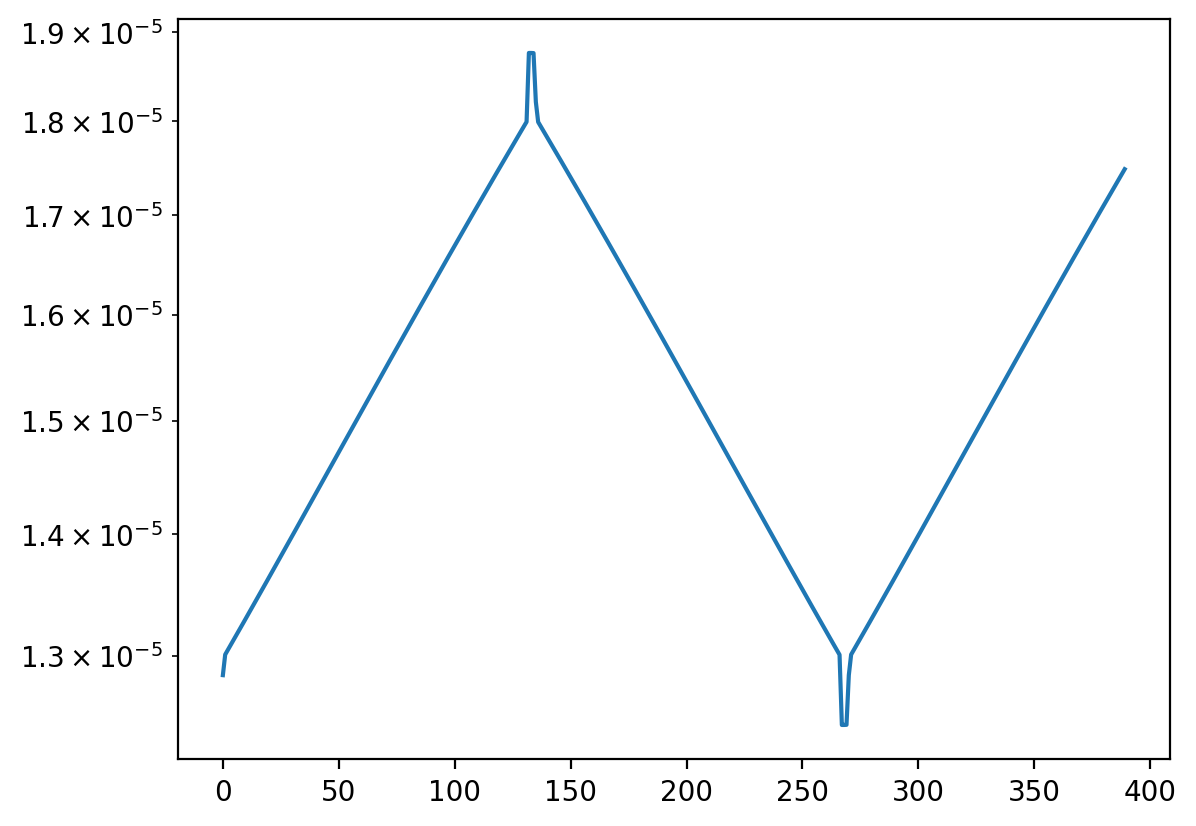

In [19]:
plt.plot(G.output.beam.stat.sigma_x)
plt.yscale("log")

Each of these parameters has a string alias that you can use to refer to the data.  These string parameters can be used in `G.plot()` and similar methods.

Here are the first 10 of those keys:

In [20]:
list(G.output.keys())[:10]

['beam_globals_energy',
 'beam_globals_energyspread',
 'beam_globals_xposition',
 'beam_globals_yposition',
 'beam_globals_xsize',
 'beam_globals_ysize',
 'beam_bunching',
 'beam_bunchingphase',
 'beam_energy',
 'beam_energyspread']

In [21]:
print("Took", G.output.run.run_time, "sec")

Took 11.069063542003278 sec


To inspect these aliases, check this dictionary:

In [22]:
print(G.output.alias["alphax"])

beam.alphax


In [23]:
G.output["alphax"] is G.output.beam.alphax

True

The above indicates that the alias `"alphax"` corresponds to the attribute ``beam.alphax``. So, you could access the data either as `G.output["alphax"]` or `G.output.beam.alphax`.

Though the former may be shorter, you can take advantage of tab completion when working with the Python classes directly.  Try typing `G.output.beam.` and then hit tab with the cursor after the final `.`. You should see a list of other output beam data.

There are many outputs. `.output_info()` gives a convenient table describing what was read in.

In [24]:
genesis.global_display_options.include_description = True

In [25]:
G.output.info()

Key,Units,Shape,Description
alphax,rad,"(1, 544)",Twiss alpha horizontal. Evaluated only at the beginning. [rad]
alphay,rad,"(1, 544)",Twiss alpha vertical. Evaluated only at the beginning. [rad]
aw,,"(4332,)","The dimensionless rms undulator parameter. For planar undulator this value is smaller by a factor $1 / \sqrt{2}$ than its K-value, while for helical undulator rms and peak values are identical."
ax,,"(4332,)",Offset of the undulator module in $x$ in meter.
ay,,"(4332,)",Offset of the undulator module in $y$ in meter.
beam_alphax,rad,"(1, 544)",Twiss alpha horizontal. Evaluated only at the beginning. [rad]
beam_alphay,rad,"(1, 544)",Twiss alpha vertical. Evaluated only at the beginning. [rad]
beam_betax,m,"(1, 544)",Twiss beta horizontal. Evaluated only at the beginning. [m]
beam_betay,m,"(1, 544)",Twiss beta vertical. Evaluated only at the beginning. [m]
beam_bunching,,"(390, 544)",Evaluated at each integration step. [unitless]


## Fields

Field files can be very large and are made readily available for lazy loading.
Loaded fields are present in `.field` attribute of the output:

In [26]:
list(G.output.field3d)

[]

For convenience, fields and particles may be automatically loaded after a run by using `run(load_fields=True, load_particles=True)` instead.
Otherwise, these can be manually loaded individually or all at once:

In [27]:
G.output.load_fields()

['end']

In [28]:
list(G.output.field3d)

['end']

This field data has two parts: basic parameters `param`, and the raw 3D complex array `dfl`:

In [29]:
G.output.field3d["end"].param

FieldFileParams(
  gridpoints=101,
  gridsize=2e-06,
  wavelength=1.3789244869952112e-10,
  slicecount=544,
  slicespacing=2.7578489739904225e-08,
)

In [30]:
G.output.field3d["end"].dfl.shape

(101, 101, 544)

`.field` is a convenience property that points to this

In [31]:
G.output.field3d["end"].param

FieldFileParams(
  gridpoints=101,
  gridsize=2e-06,
  wavelength=1.3789244869952112e-10,
  slicecount=544,
  slicespacing=2.7578489739904225e-08,
)

## Visualize Field

In [32]:
# Sum over y and compute the absolute square
dfl = G.output.field3d["end"].dfl
param = G.output.field3d["end"].param
dat2 = np.abs(np.sum(dfl, axis=1)) ** 2

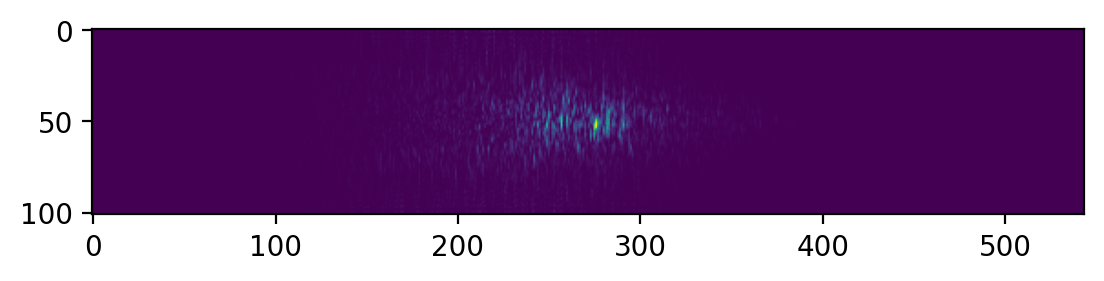

In [33]:
plt.imshow(dat2)

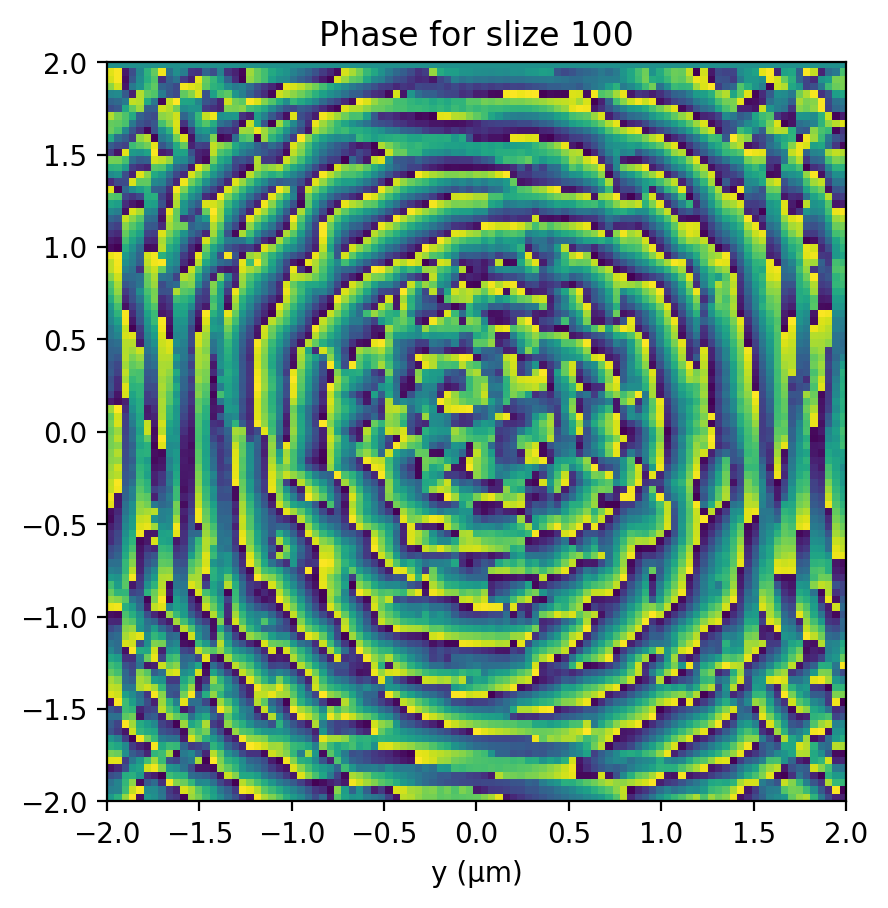

In [34]:
def plot_slice(i=0):
    dat = np.angle(dfl[:, :, i])

    dx = param.gridsize * 1e6
    plt.xlabel("x (µm)")
    plt.xlabel("y (µm)")
    plt.title(f"Phase for slize {i}")
    plt.imshow(dat.T, origin="lower", extent=[-dx, dx, -dx, dx])


plot_slice(i=100)

# Particles

Particle files can be read in as [openPMD-beamphysics](https://christophermayes.github.io/openPMD-beamphysics/) `ParticleGroup` objects.
These are loaded only on-demand by default (`run(load_particles=False)`). They may also be loaded all at once, with `load_particles()`.

In [35]:
list(G.output.particle_files)

['end']

In [36]:
G.output.load_particles()

['end']

After loading particles, use the `.particles` attribute to access their data:

In [37]:
G.output.particles

{'end': <ParticleGroup with 557056 particles at 0x176409970>}

In [38]:
P = G.output.particles["end"]

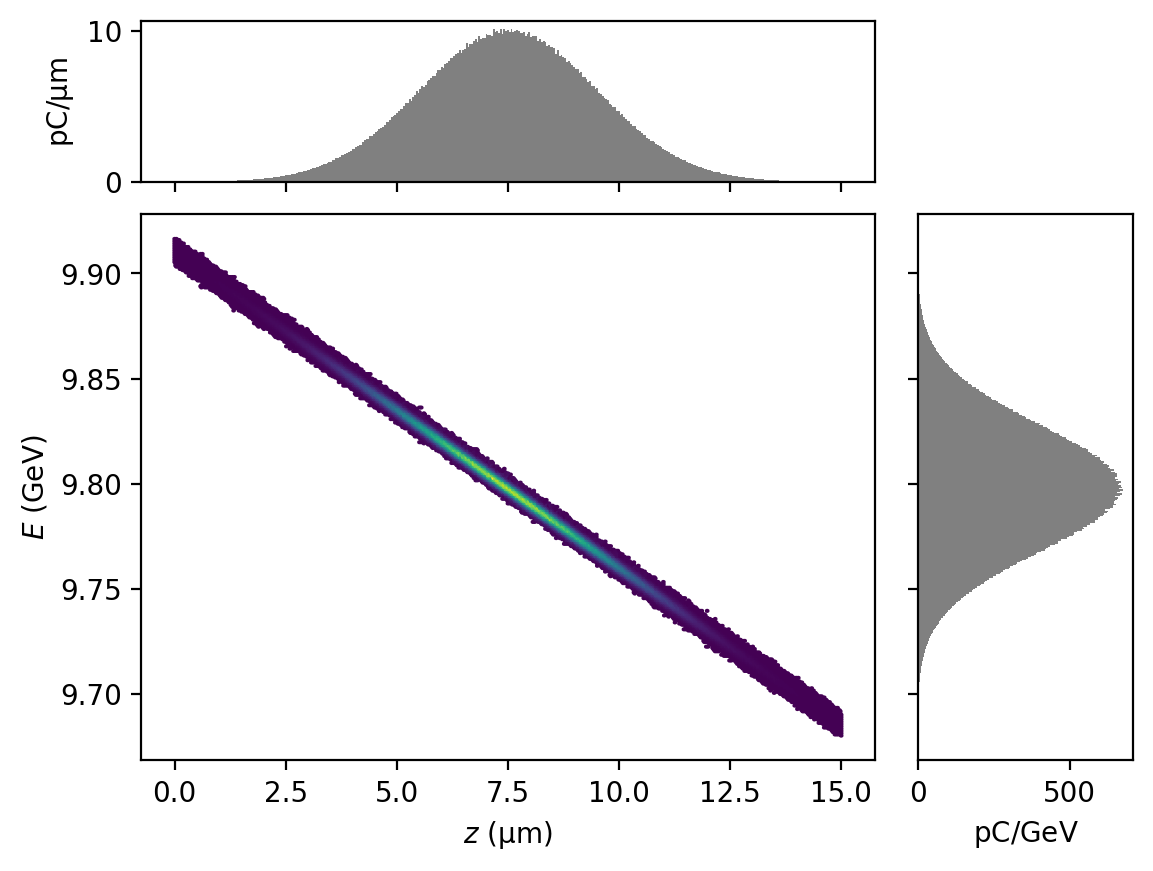

In [39]:
P.plot("z", "energy")

Change to z coordinates to see the current. Note that the head of the bunch is now on the left.

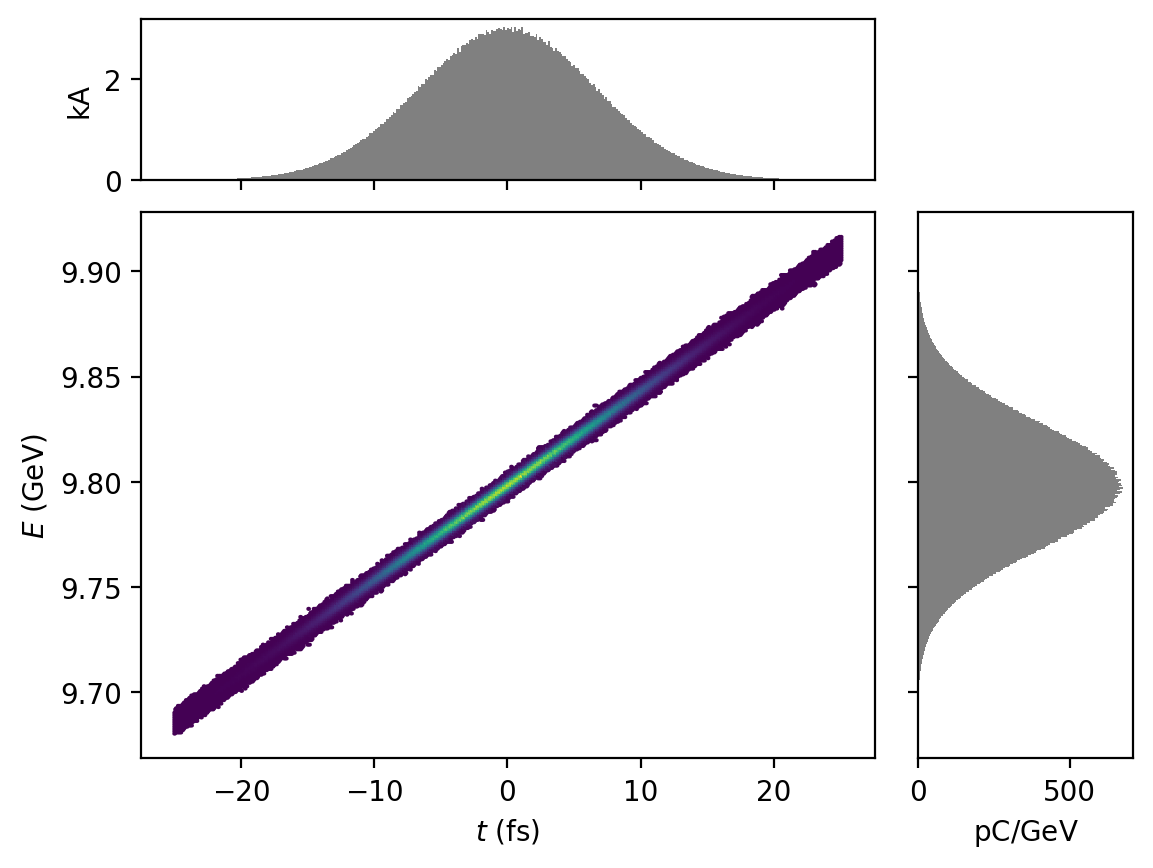

In [40]:
P.drift_to_z()
P.plot("t", "energy")

Check some statistics

In [41]:
P["norm_emit_x"], P["norm_emit_y"], P["mean_gamma"]

(np.float64(4.000048859206932e-07),
 np.float64(4.000067746321235e-07),
 np.float64(19174.078130220394))

## Bunching

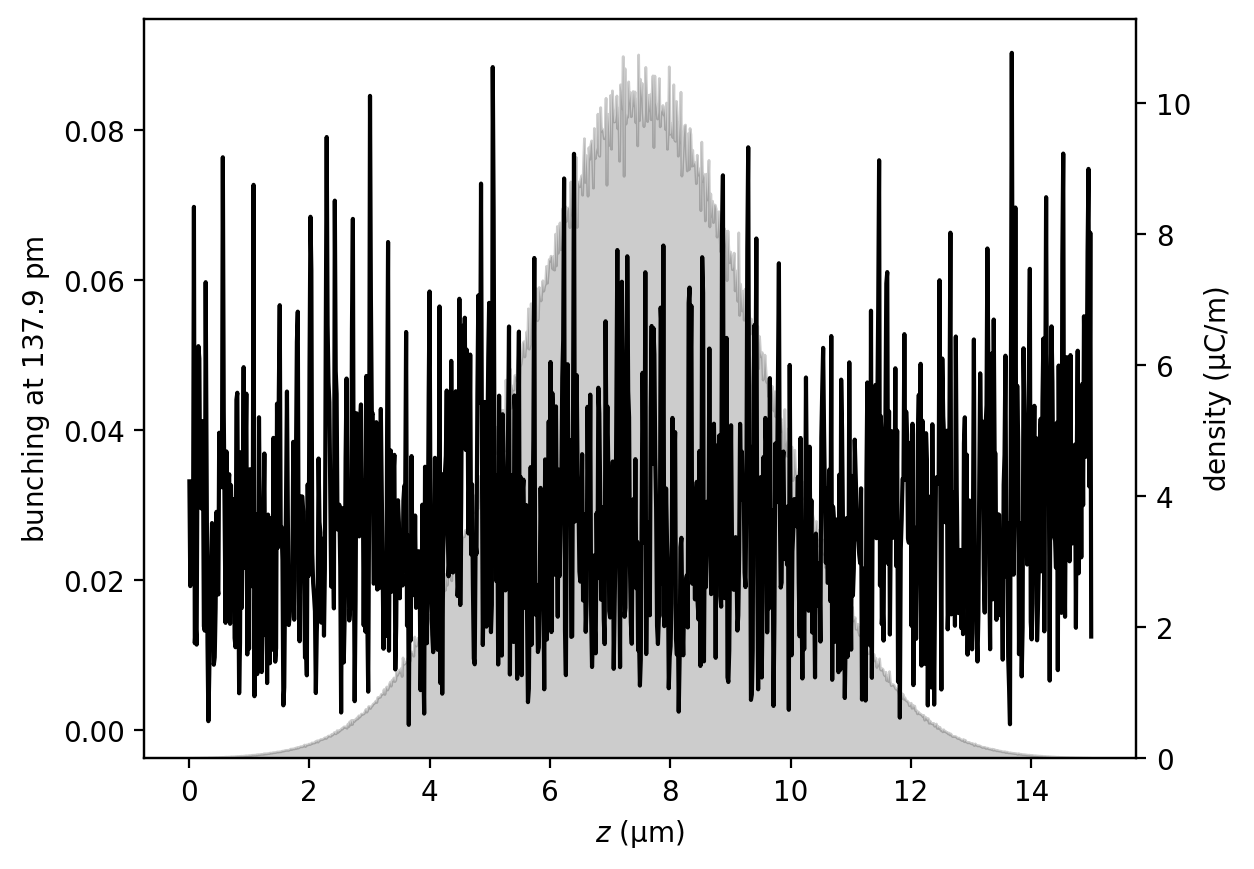

In [42]:
wavelength = G.input.main.setup.lambda0
bunching_key = f"bunching_{wavelength}"
P.drift_to_t()

P.slice_plot(bunching_key, n_slice=1000)

In [43]:
# Genesis4 data
final_bunching = G.output.beam.bunching[-1, :]
current = G.output.beam.current[-1, :]
s = G.output.globals.s


# ParticleGroup data
ss = P.slice_statistics(bunching_key, n_slice=len(s))
ss.keys()
x = ss["mean_z"]
y = ss[bunching_key]

Compare 

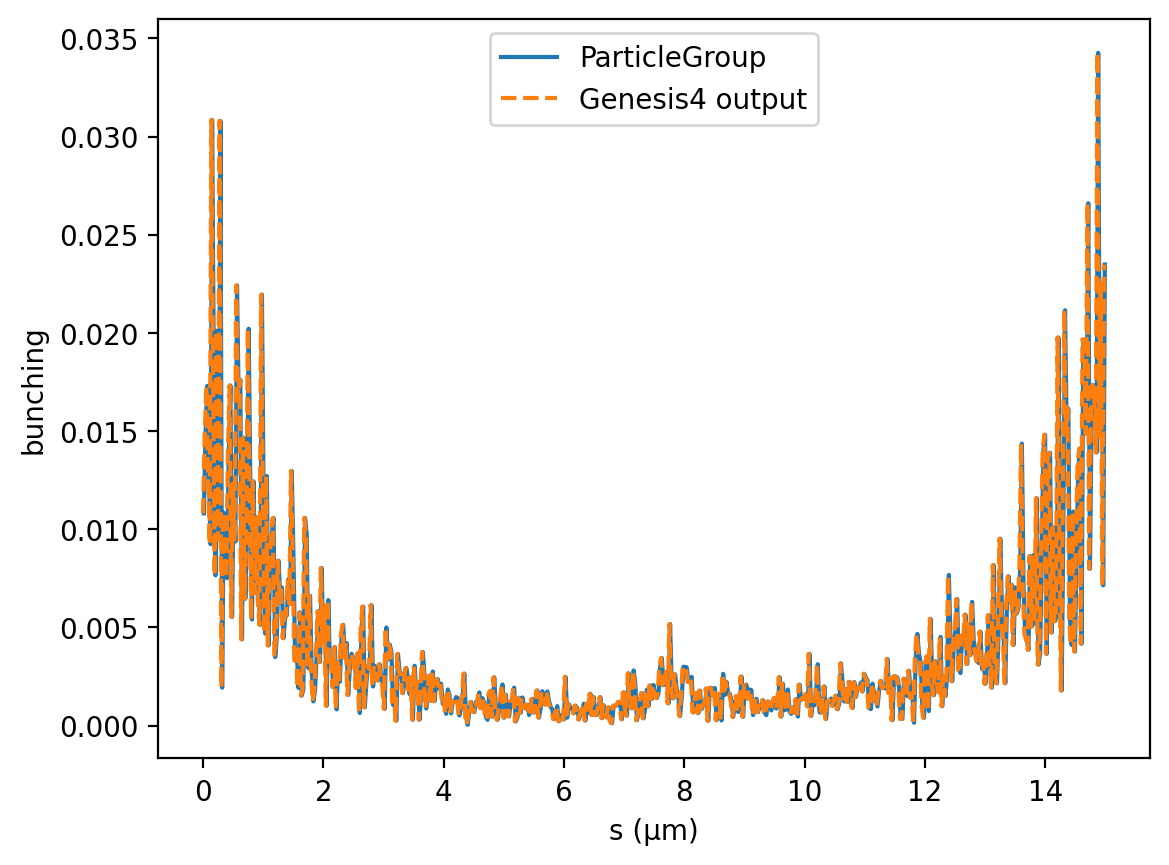

In [44]:
fig, ax = plt.subplots()
ax.plot(x * 1e6, y, label="ParticleGroup")
ax.plot(s * 1e6, final_bunching, "--", label="Genesis4 output")
ax.set_xlabel("s (µm)")
ax.set_ylabel("bunching")
plt.legend()

This is the average bunching from the ParticleGroup:

In [45]:
P.bunching(wavelength)

np.complex128(0.0001135601590763094+7.685175664329504e-05j)

That agrees with the appropriate averaging of Genesis4's bunching calc:

In [46]:
G.stat("bunching")[-1]

np.float64(0.0001371207578264911)

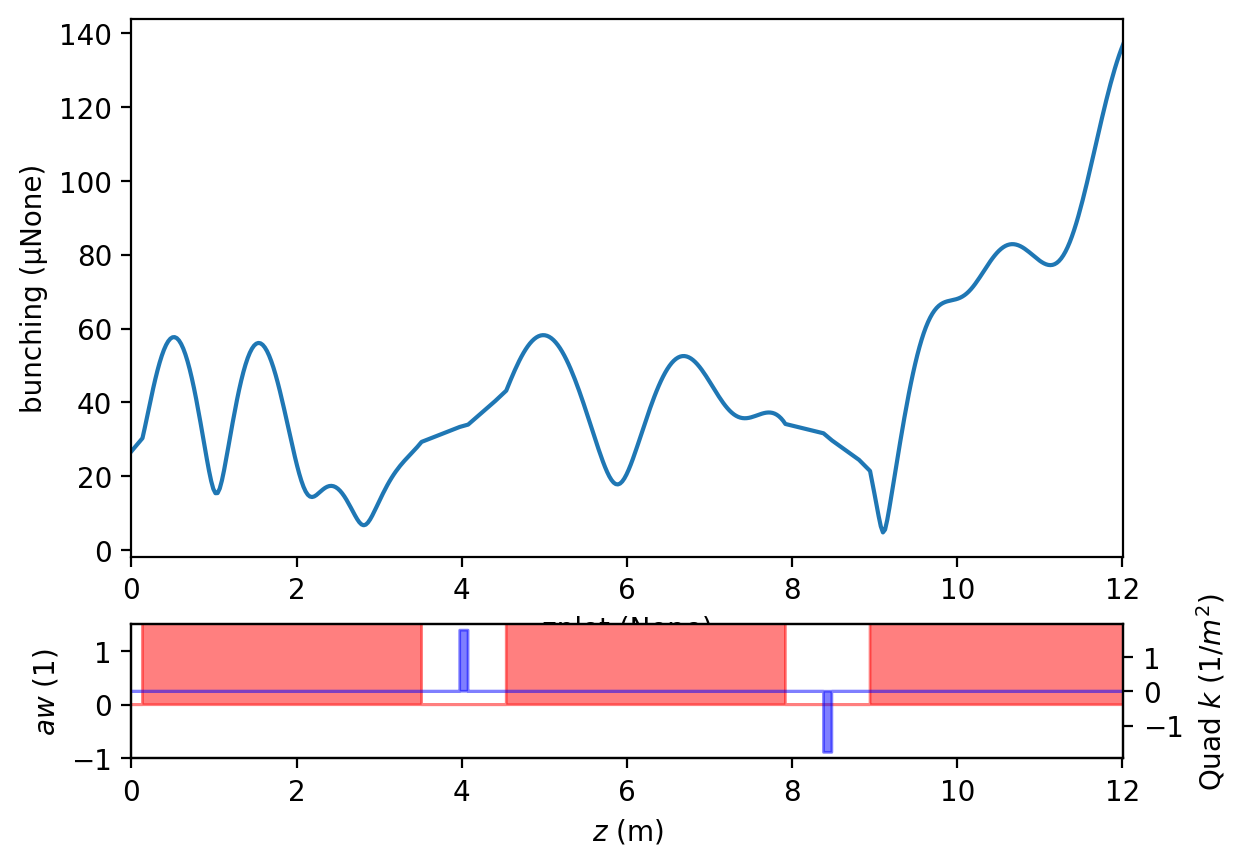

In [47]:
G.plot("bunching")

Check the total charge in pC:

In [48]:
P["charge"] / 1e-12  # pC

np.float64(50.1584225612439)

## Units

Each item in the output class should have corresponding units.

In [49]:
G.output.units("beam_betax")

pmd_unit('m', 1, (1, 0, 0, 0, 0, 0, 0))

# Plotting

Convenient plotting of the data in `.output` is provided by `.plot`. The default is to plot the power. Depending on the key these statistics are averaged or integrated over the slices. Some keys like `power` are converted to `peak_power`, while `field_energy` is the integral over `field_power`. 

In [50]:
print(G.output.alias["power"])

field.power


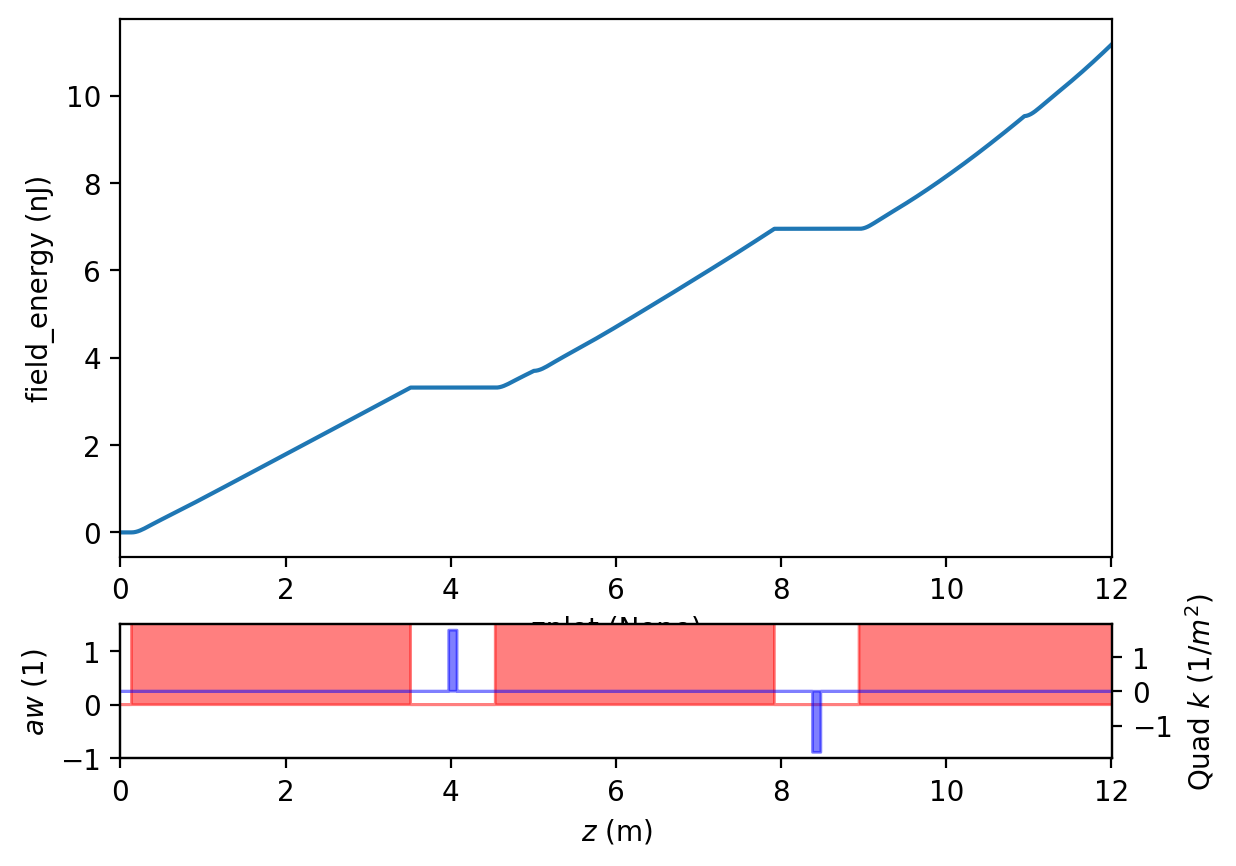

In [51]:
G.plot()

Left and right axes can be set this way:

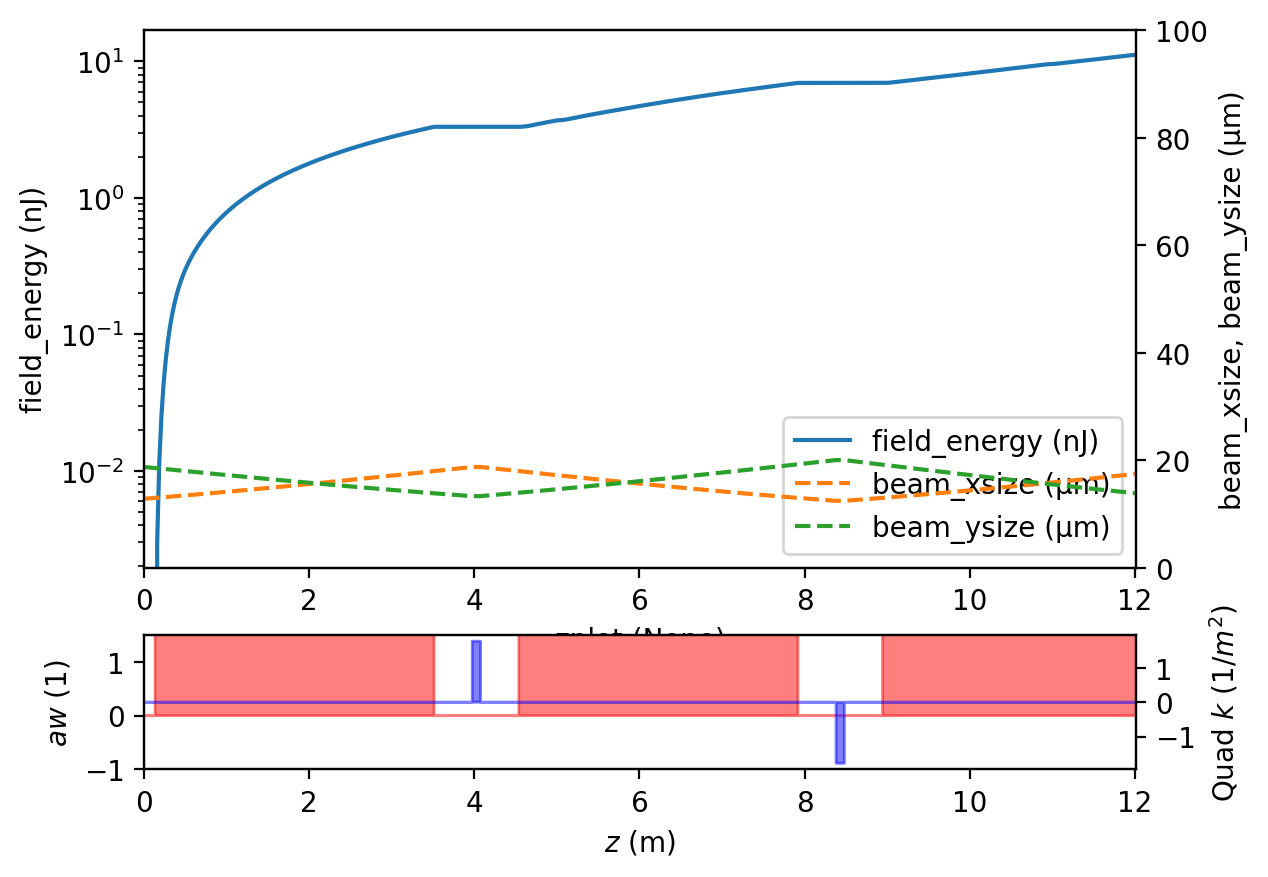

In [52]:
G.plot("field_energy", yscale="log", y2=["beam_xsize", "beam_ysize"], ylim2=(0, 100e-6))

By default, these plots average over slices. In the case of beam sizes, simply averaging these does not take into account the effect of misaligned slices. To plot this, LUME-Genesis provides additional `beam_sigma_x`, `beam_sima_y`, `beam_sigma_energy` keys that properly project these quantities. The difference is noticable in the energy spread calculation:

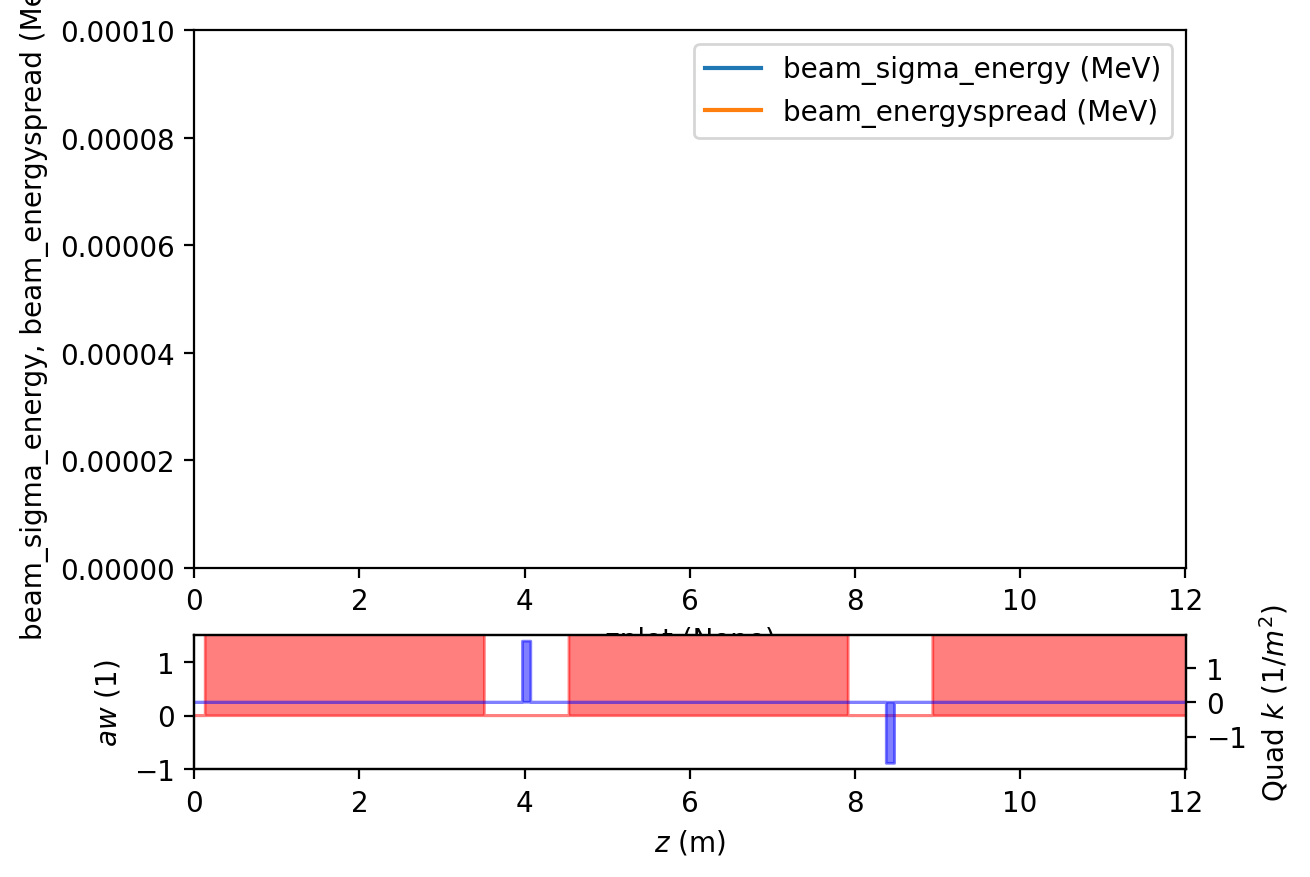

In [53]:
G.plot(["beam_sigma_energy", "beam_energyspread"], ylim=(0, 100))

The field slice statistics are power-weighted averages:

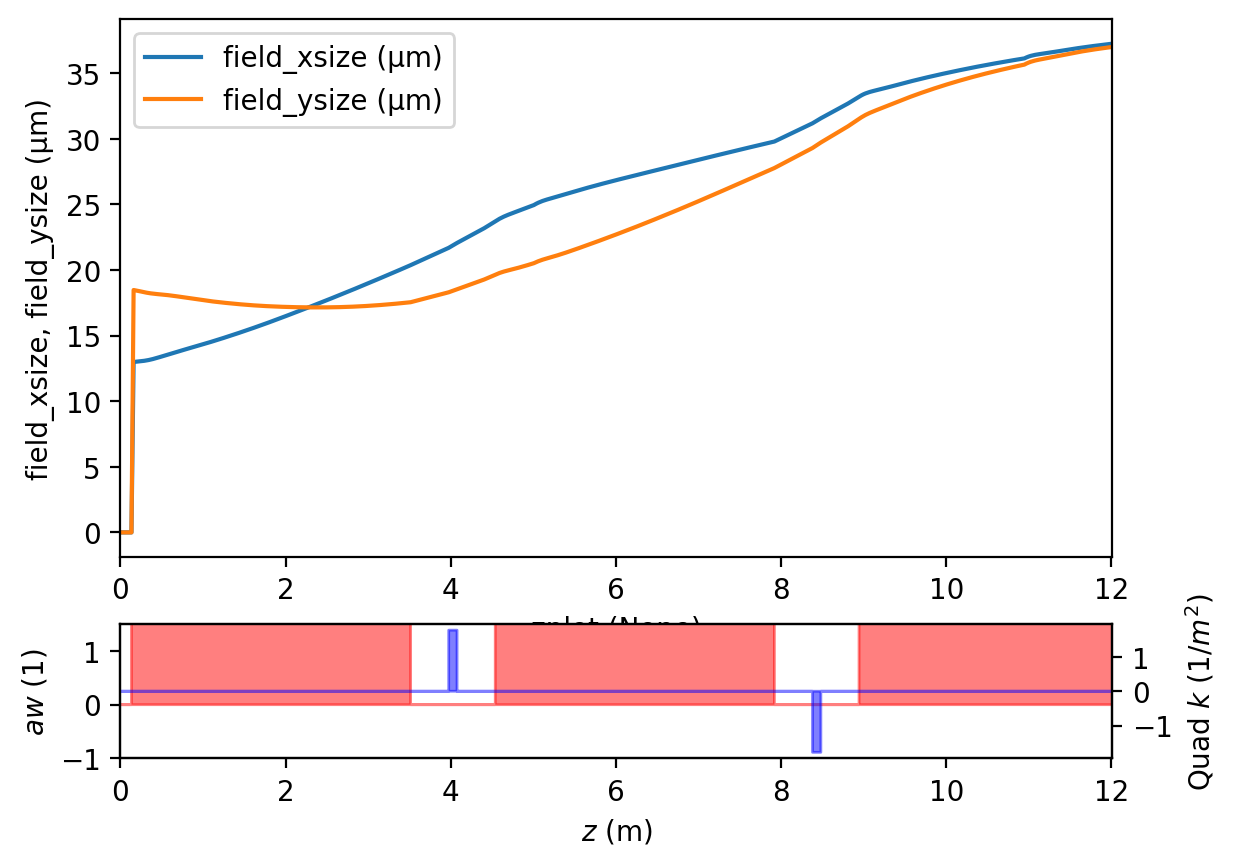

In [54]:
G.plot(["field_xsize", "field_ysize"])

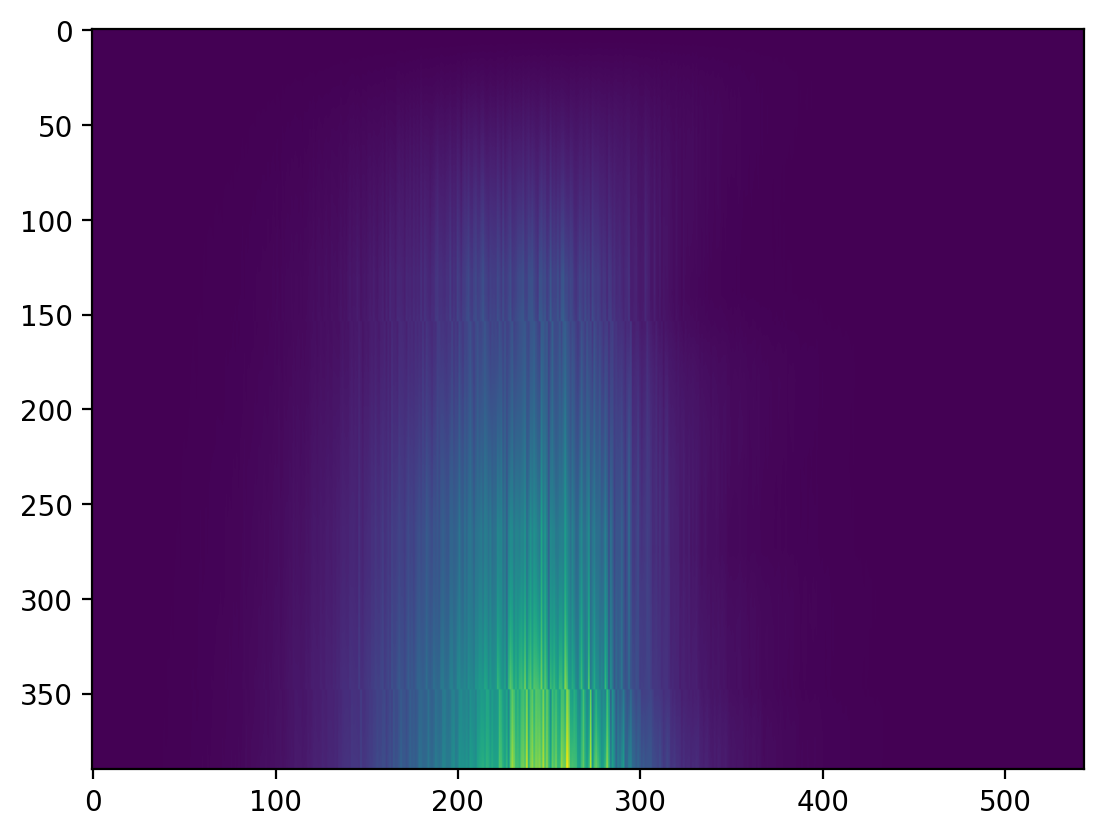

In [55]:
plt.imshow(G.output.field.power, aspect="auto");

## Archiving

In [56]:
G.archive("archived.h5")

Grestored = Genesis4.from_archive("archived.h5")

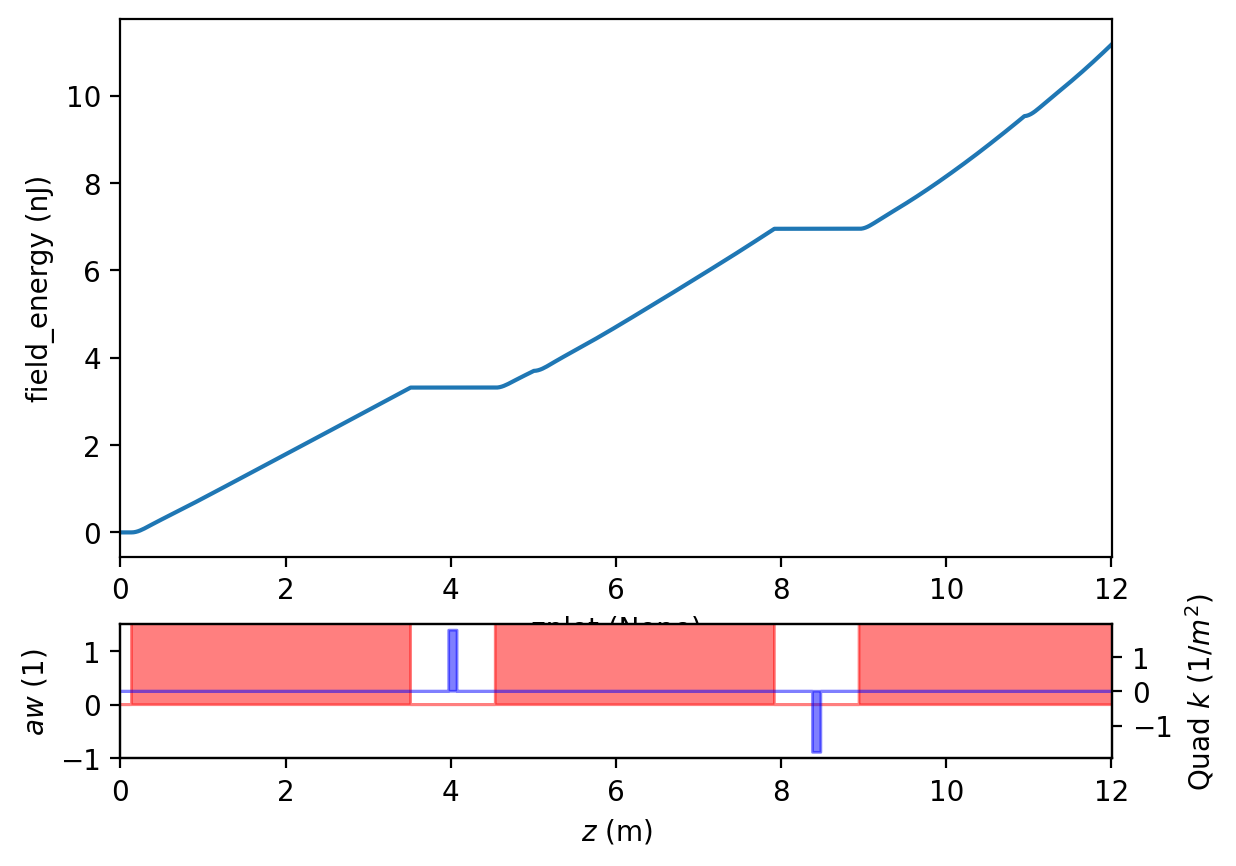

In [57]:
Grestored.output.plot()

### Check that the restored object is the same

The Genesis4 object as well as the input, output, and all namelists support equality checks:

In [58]:
Grestored == G

True

In [59]:
Grestored.input == G.input

True

In [60]:
Grestored.output == G.output

True

# Manual loading of Genesis4 data

Sometimes it is necessary to run Genesis4 manually, and load the output into LUME-Genesis for further analysis.

First, let's create some input to run in a local directory `temp/`:

In [61]:
import os

os.makedirs("temp/", exist_ok=True)
G.write_input("temp/")

Now run on the command line:

In [62]:
!cd temp; ./run | tee log.txt

---------------------------------------------
GENESIS - Version 4.6.6 has started...
Compile info: Compiled by runner at 2024-06-10 16:27:02 [UTC] from Git Commit ID: 
Starting Time: Mon Aug 12 15:10:44 2024

MPI-Comm Size: 16 nodes

Opened input file genesis4.in
Parsing lattice file hxr.lat ...
Setting up time window of 15.0027 microns with 544 sample points...
Generating input radiation field for HARM = 1 ...
Adding profile with label: beamcurrent
Adding profile with label: beamgamma
Generating input particle distribution...

Running Core Simulation...
Time-dependent run with 544 slices for a time window of 15.0027 microns
Initial analysis of electron beam and radiation field...
  Calculation: 0% done
  Calculation: 10% done
  Calculation: 20% done
  Calculation: 30% done
  Calculation: 40% done
  Calculation: 50% done
  Calculation: 60% done
  Calculation: 70% done
  Calculation: 80% done
  Calculation: 90% done
  Calculation: 100% done
  Calculation: 110% done
Calculation terminate

Using the `use_temp_dir=False` and `workdir` options, the input and output data can be loaded into a new Genesis4 object:

In [63]:
G2 = Genesis4("genesis4.in", use_temp_dir=False, workdir="temp/", verbose=True)
G2.configure()
output = G2.load_output()

Configured to run in: temp/


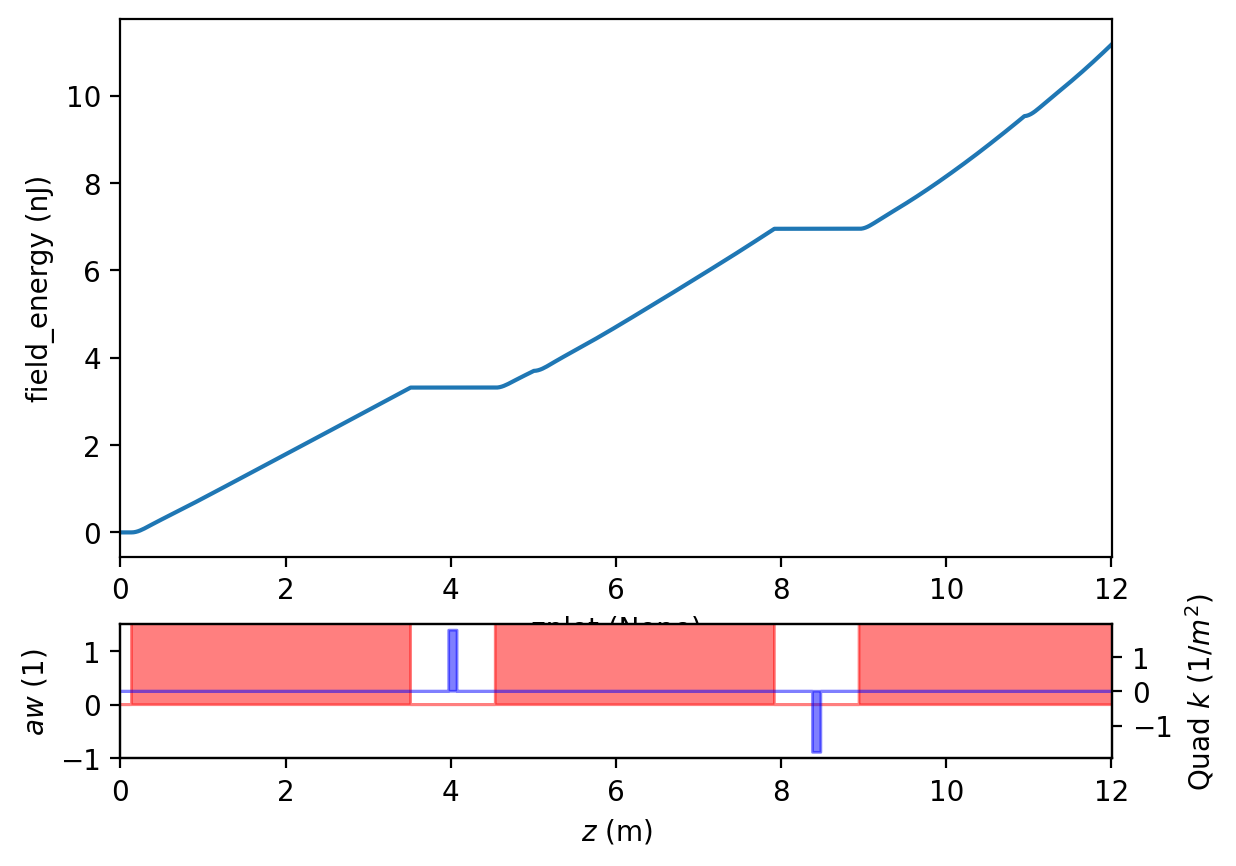

In [64]:
output.plot()

# Cleanup

In [65]:
import shutil

shutil.rmtree("temp")
os.remove("archived.h5")